In [41]:
%matplotlib widget

import os
import sys
import matplotlib.pyplot as plt
from IPython import embed
import pickle
import numpy as np
import torch

sys.path.append(os.path.abspath("/develop/code/evaluation"))
import evaluation_3 as eval

path_results = "/develop/results/spie_journal_2023"
colors = ['darkgreen','purple','#4e88d9'] 

-3.0018585 2.671871
-3.0018585 2.671871
-3.570556 3.2203596
-3.84579 3.3966093
-3.2771842 3.3966093


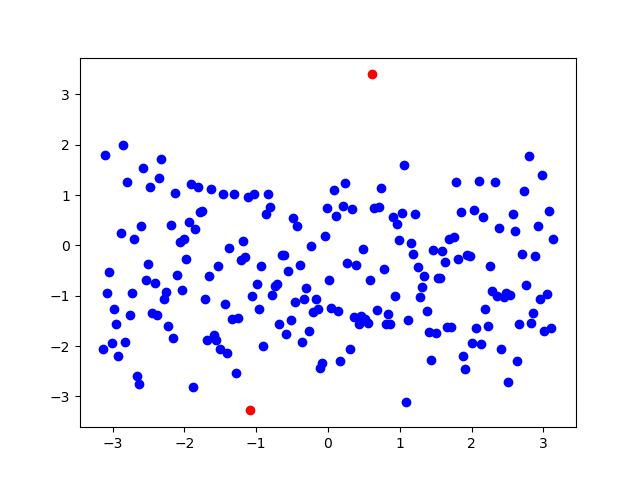

In [2]:
exp_name = "all_on" # 0. phase | 1. curv | 2. recon/thermo | 3. phase/thermo 

folder_name = exp_name
index = 0

encoder_train = pickle.load(open(os.path.join(path_results, folder_name, "train_info", "encoder.pkl"), "rb"))
recon_train = pickle.load(open(os.path.join(path_results, folder_name, "train_info", "recon.pkl"), "rb"))

encoder_valid =pickle.load(open(os.path.join(path_results, folder_name, "valid_info", "encoder.pkl"), "rb"))
recon_valid = pickle.load(open(os.path.join(path_results, folder_name, "valid_info", "recon.pkl"), "rb"))

resim_train_eval = pickle.load(open(os.path.join(path_results, folder_name, "train_info", "resim.pkl"), "rb"))
resim_valid_eval = pickle.load(open(os.path.join(path_results, folder_name, "valid_info", "resim.pkl"), "rb"))

phase_train_truth, phase_train_pred = encoder_train['phase_truth'].flatten(), encoder_train['phase_pred'].flatten()
phase_valid_truth, phase_valid_pred = encoder_valid['phase_truth'].flatten(), encoder_valid['phase_pred'].flatten()
der_train_truth, der_train_pred = encoder_train['deriv_truth'].flatten(), encoder_train['deriv_pred'].flatten()
der_valid_truth, der_valid_pred = encoder_valid['deriv_truth'].flatten(), encoder_valid['deriv_pred'].flatten()
int_train_truth, int_train_pred = encoder_train['intensity_truth'].flatten(), encoder_train['intensity_pred'].flatten()

print(phase_train_truth.min(), phase_train_truth.max())
print(phase_valid_truth.min(), phase_valid_truth.max()) # it makes sense that these are the same as the train values because these are the 'real' mins and maxes represented in the dataset!

print(phase_train_pred.min(), phase_train_pred.max())
print(phase_valid_pred.min(), phase_valid_pred.max()) # these go most outside the (-pi, pi) bounds so i will play with this set

temp_valid = phase_valid_pred[400:600] # i just want to grab a small batch to work with - needs to have min and max outside (-pi, pi)
temp_valid.shape
print(temp_valid.min(), temp_valid.max())

inside_idx = (temp_valid >= -np.pi) & (temp_valid <= np.pi)
outside_idx = ~inside_idx

plt.close("all")
x = np.linspace(-np.pi, np.pi, len(temp_valid))
x_in = x[inside_idx]
x_out = x[outside_idx]

y_in = temp_valid[inside_idx]
y_out = temp_valid[outside_idx]

fig, ax = plt.subplots()
ax.scatter(x_in, y_in, c='b')
ax.scatter(x_out, y_out, c='r')

In [64]:
# i think i'll just make up some values actually.
min = -torch.pi - 1
max = torch.pi + 1
x = np.random.uniform(min, max, 20)

In [65]:
# this lets me plot the values outside my -pi to pi range in red.
def sort_list(x):
    inside_idx = (x >= -np.pi) & (x <= np.pi)
    outside_idx = ~inside_idx

    x_in = x[inside_idx]
    x_out = x[outside_idx]

    return x_in, x_out # meaning, x "in" the range, and x "out of" the range

# this takes in a value and returns the value if it's between -pi and pi, else an equivalent value between -pi and pi
def constrain_phase(values):
    #wrapped_values = (values + np.pi) % (2 * np.pi) - np.pi
    values = torch.from_numpy(values)
    old = torch.remainder((values + torch.pi), (2*torch.pi)) - torch.pi
    new = torch.atan2(torch.sin(values), torch.cos(values))
    return old, new

x_in, x_out = sort_list(x)

In [66]:
x

array([-1.45487603,  1.65910893, -1.94281831,  0.15703801, -2.67159245,
       -0.26633777, -0.42273635, -0.86091605,  2.41807246, -0.05468356,
        1.85500194,  2.42716408, -1.2298534 ,  3.39323606,  1.76338661,
        3.29047574, -0.6609292 , -0.26907017,  3.34580384,  1.10620785])

In [67]:
old, new = constrain_phase(x)

In [68]:
print(old)
print("\n")
print(new)

tensor([-1.4549,  1.6591, -1.9428,  0.1570, -2.6716, -0.2663, -0.4227, -0.8609,
         2.4181, -0.0547,  1.8550,  2.4272, -1.2299, -2.8899,  1.7634, -2.9927,
        -0.6609, -0.2691, -2.9374,  1.1062], dtype=torch.float64)


tensor([-1.4549,  1.6591, -1.9428,  0.1570, -2.6716, -0.2663, -0.4227, -0.8609,
         2.4181, -0.0547,  1.8550,  2.4272, -1.2299, -2.8899,  1.7634, -2.9927,
        -0.6609, -0.2691, -2.9374,  1.1062], dtype=torch.float64)


In [70]:
(old == new)

tensor([ True,  True,  True,  True,  True,  True,  True, False,  True, False,
         True,  True,  True, False,  True, False,  True, False, False,  True])

In [74]:
for i, (x, y) in enumerate(zip(old, new)):
    if x!=y:
        print(i)
        print(f"\t{old[i]}\n\t{new[i]}")

7
	-0.8609160466030059
	-0.8609160466030058
9
	-0.0546835618299939
	-0.054683561829993906
13
	-2.889949249287784
	-2.8899492492877843
15
	-2.9927095671259094
	-2.99270956712591
17
	-0.2690701682878953
	-0.26907016828789526
18
	-2.937381464516214
	-2.9373814645162146


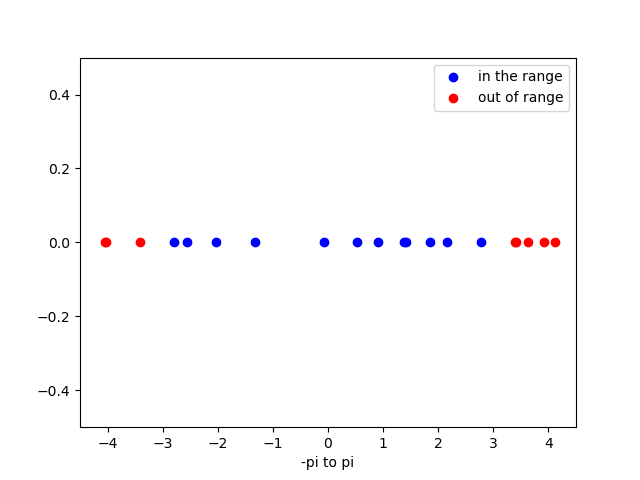

In [50]:
fig, ax = plt.subplots()

ax.scatter(x_in, np.zeros(len(x_in)), c='b', label="in the range")
ax.scatter(x_out, np.zeros(len(x_out)), c='r', label="out of range")
ax.set_xlabel("-pi to pi")
ax.set_ylim([-0.5,0.5])
ax.set_xlim([-4.5,4.5])
ax.legend()

In [51]:
wrapped_x = constrain_phase(x)
x_in_wrapped, x_out_wrapped, = sort_list(wrapped_x)

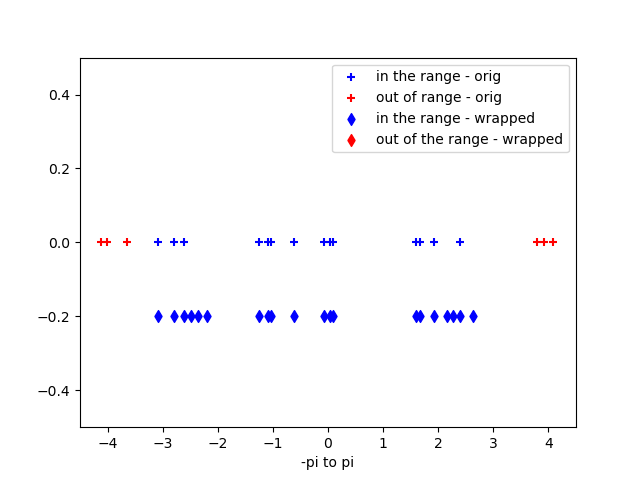

In [40]:
plt.close("all")
fig, ax = plt.subplots()
ax.scatter(x_in, np.zeros(len(x_in)), c='b', marker="+", label="in the range - orig")
ax.scatter(x_out, np.zeros(len(x_out)), c='r', marker="+", label="out of range - orig")
ax.scatter(x_in_wrapped, np.ones(len(x_in_wrapped))*-0.2, c='b', marker='d', label="in the range - wrapped")
ax.scatter(x_out_wrapped, np.ones(len(x_out_wrapped))*-0.2, c='r', marker='d', label="out of the range - wrapped")
ax.set_xlabel("-pi to pi")
ax.set_ylim([-0.5,0.5])
ax.set_xlim([-4.5,4.5])
ax.legend()

In [ ]:
# def wrap_to_pi(value):
#     wrapped_value = (value + np.pi) % (2 * np.pi) - np.pi
#     return wrapped_value

# # Example usage
# input_value = x[0]  # Example value outside the -pi to pi range
# print("Input value:", input_value)
# print(np.sin(input_value))
# wrapped_value = wrap_to_pi(input_value)
# print("Wrapped value:", wrapped_value)
# print(np.sin(wrapped_value))

# input_value = x[1]
# print("Input value:", input_value)
# print(np.sin(input_value))
# wrapped_value = wrap_to_pi(input_value)
# print("Wrapped value:", wrapped_value)
# print(np.sin(wrapped_value))